# Logistic regression


---





Logistic regression, despite its name, is a linear model for classification rather than regression. Logistic regression is also known in the literature as logit regression, maximum-entropy classification (MaxEnt) or the log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

Logistic regression is implemented in LogisticRegression. This implementation can fit binary, One-vs-Rest, or multinomial logistic regression with optional 
, 
 or Elastic-Net regularization.

# L1 Penalty and Sparsity in Logistic Regression
Comparison of the sparsity (percentage of zero coefficients) of solutions when L1, L2 and Elastic-Net penalty are used for different values of C. We can see that large values of C give more freedom to the model. Conversely, smaller values of C constrain the model more. In the L1 penalty case, this leads to sparser solutions. As expected, the Elastic-Net penalty sparsity is between that of L1 and L2.

We classify 8x8 images of digits into two classes: 0-4 against 5-9. The visualization shows coefficients of the models for varying C.

C=1.00
Sparsity with L1 penalty:                6.25%
Sparsity with Elastic-Net penalty:       4.69%
Sparsity with L2 penalty:                4.69%
Score with L1 penalty:                   0.90
Score with Elastic-Net penalty:          0.90
Score with L2 penalty:                   0.90
C=0.10
Sparsity with L1 penalty:                29.69%
Sparsity with Elastic-Net penalty:       14.06%
Sparsity with L2 penalty:                4.69%
Score with L1 penalty:                   0.90
Score with Elastic-Net penalty:          0.90
Score with L2 penalty:                   0.90
C=0.01
Sparsity with L1 penalty:                84.38%
Sparsity with Elastic-Net penalty:       68.75%
Sparsity with L2 penalty:                4.69%
Score with L1 penalty:                   0.86
Score with Elastic-Net penalty:          0.88
Score with L2 penalty:                   0.89


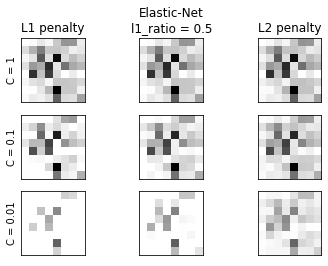

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

X, y = datasets.load_digits(return_X_y=True)

X = StandardScaler().fit_transform(X)

# classify small against large digits
y = (y > 4).astype(int)

l1_ratio = 0.5  # L1 weight in the Elastic-Net regularization

fig, axes = plt.subplots(3, 3)

# Set regularization parameter
for i, (C, axes_row) in enumerate(zip((1, 0.1, 0.01), axes)):
    # turn down tolerance for short training time
    clf_l1_LR = LogisticRegression(C=C, penalty='l1', tol=0.01, solver='saga')
    clf_l2_LR = LogisticRegression(C=C, penalty='l2', tol=0.01, solver='saga')
    clf_en_LR = LogisticRegression(C=C, penalty='elasticnet', solver='saga',
                                   l1_ratio=l1_ratio, tol=0.01)
    clf_l1_LR.fit(X, y)
    clf_l2_LR.fit(X, y)
    clf_en_LR.fit(X, y)

    coef_l1_LR = clf_l1_LR.coef_.ravel()
    coef_l2_LR = clf_l2_LR.coef_.ravel()
    coef_en_LR = clf_en_LR.coef_.ravel()

    # coef_l1_LR contains zeros due to the
    # L1 sparsity inducing norm

    sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
    sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100
    sparsity_en_LR = np.mean(coef_en_LR == 0) * 100

    print("C=%.2f" % C)
    print("{:<40} {:.2f}%".format("Sparsity with L1 penalty:", sparsity_l1_LR))
    print("{:<40} {:.2f}%".format("Sparsity with Elastic-Net penalty:",
                                  sparsity_en_LR))
    print("{:<40} {:.2f}%".format("Sparsity with L2 penalty:", sparsity_l2_LR))
    print("{:<40} {:.2f}".format("Score with L1 penalty:",
                                 clf_l1_LR.score(X, y)))
    print("{:<40} {:.2f}".format("Score with Elastic-Net penalty:",
                                 clf_en_LR.score(X, y)))
    print("{:<40} {:.2f}".format("Score with L2 penalty:",
                                 clf_l2_LR.score(X, y)))

    if i == 0:
        axes_row[0].set_title("L1 penalty")
        axes_row[1].set_title("Elastic-Net\nl1_ratio = %s" % l1_ratio)
        axes_row[2].set_title("L2 penalty")

    for ax, coefs in zip(axes_row, [coef_l1_LR, coef_en_LR, coef_l2_LR]):
        ax.imshow(np.abs(coefs.reshape(8, 8)), interpolation='nearest',
                  cmap='binary', vmax=1, vmin=0)
        ax.set_xticks(())
        ax.set_yticks(())

    axes_row[0].set_ylabel('C = %s' % C)

plt.show()

# Regularization path of L1- Logistic Regression
Train l1-penalized logistic regression models on a binary classification problem derived from the Iris dataset.

The models are ordered from strongest regularized to least regularized. The 4 coefficients of the models are collected and plotted as a “regularization path”: on the left-hand side of the figure (strong regularizers), all the coefficients are exactly 0. When regularization gets progressively looser, coefficients can get non-zero values one after the other.

Here we choose the liblinear solver because it can efficiently optimize for the Logistic Regression loss with a non-smooth, sparsity inducing l1 penalty.

Also note that we set a low value for the tolerance to make sure that the model has converged before collecting the coefficients.

We also use warm_start=True which means that the coefficients of the models are reused to initialize the next model fit to speed-up the computation of the full-path.

Computing regularization path ...
This took 0.069s


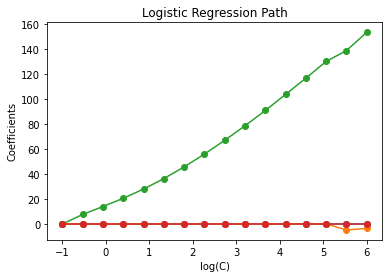

In [2]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn import datasets
from sklearn.svm import l1_min_c

iris = datasets.load_iris()
X = iris.data
y = iris.target

X = X[y != 2]
y = y[y != 2]

X /= X.max()  # Normalize X to speed-up convergence

# #############################################################################
# Demo path functions

cs = l1_min_c(X, y, loss='log') * np.logspace(0, 7, 16)


print("Computing regularization path ...")
start = time()
clf = linear_model.LogisticRegression(penalty='l1', solver='liblinear',
                                      tol=1e-6, max_iter=int(1e6),
                                      warm_start=True,
                                      intercept_scaling=10000.)
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())
print("This took %0.3fs" % (time() - start))

coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_, marker='o')
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.axis('tight')
plt.show()

# Plot multinomial and One-vs-Rest Logistic Regression
Plot decision surface of multinomial and One-vs-Rest Logistic Regression. The hyperplanes corresponding to the three One-vs-Rest (OVR) classifiers are represented by the dashed lines.

training score : 0.995 (multinomial)
training score : 0.976 (ovr)


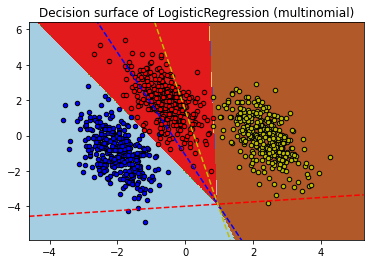

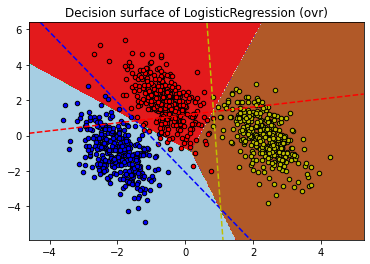

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression

# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
transformation = [[0.4, 0.2], [-0.4, 1.2]]
X = np.dot(X, transformation)

for multi_class in ('multinomial', 'ovr'):
    clf = LogisticRegression(solver='sag', max_iter=100, random_state=42,
                             multi_class=multi_class).fit(X, y)

    # print the training scores
    print("training score : %.3f (%s)" % (clf.score(X, y), multi_class))

    # create a mesh to plot in
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.title("Decision surface of LogisticRegression (%s)" % multi_class)
    plt.axis('tight')

    # Plot also the training points
    colors = "bry"
    for i, color in zip(clf.classes_, colors):
        idx = np.where(y == i)
        plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired,
                    edgecolor='black', s=20)

    # Plot the three one-against-all classifiers
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    coef = clf.coef_
    intercept = clf.intercept_

    def plot_hyperplane(c, color):
        def line(x0):
            return (-(x0 * coef[c, 0]) - intercept[c]) / coef[c, 1]
        plt.plot([xmin, xmax], [line(xmin), line(xmax)],
                 ls="--", color=color)

    for i, color in zip(clf.classes_, colors):
        plot_hyperplane(i, color)

plt.show()

# Multiclass sparse logistic regression on 20newgroups
Comparison of multinomial logistic L1 vs one-versus-rest L1 logistic regression to classify documents from the newgroups20 dataset. Multinomial logistic regression yields more accurate results and is faster to train on the larger scale dataset.

Here we use the l1 sparsity that trims the weights of not informative features to zero. This is good if the goal is to extract the strongly discriminative vocabulary of each class. If the goal is to get the best predictive accuracy, it is better to use the non sparsity-inducing l2 penalty instead.

A more traditional (and possibly better) way to predict on a sparse subset of input features would be to use univariate feature selection followed by a traditional (l2-penalised) logistic regression model.

Automatically created module for IPython interactive environment
Dataset 20newsgroup, train_samples=9000, n_features=130107, n_classes=20
[model=One versus Rest, solver=saga] Number of epochs: 1
[model=One versus Rest, solver=saga] Number of epochs: 2
[model=One versus Rest, solver=saga] Number of epochs: 4
Test accuracy for model ovr: 0.7490
% non-zero coefficients for model ovr, per class:
 [0.31743104 0.36815852 0.4181174  0.46115889 0.24595141 0.41350581
 0.31281945 0.27054655 0.58720899 0.32972861 0.4158116  0.3312658
 0.41888599 0.41120001 0.59643217 0.31666244 0.34279478 0.28130692
 0.35278655 0.24748861]
Run time (4 epochs) for model ovr:4.02
[model=Multinomial, solver=saga] Number of epochs: 1
[model=Multinomial, solver=saga] Number of epochs: 3
[model=Multinomial, solver=saga] Number of epochs: 7
Test accuracy for model multinomial: 0.7450
% non-zero coefficients for model multinomial, per class:
 [0.13219888 0.11452112 0.13066169 0.13681047 0.12066991 0.15909982
 0.13450468 

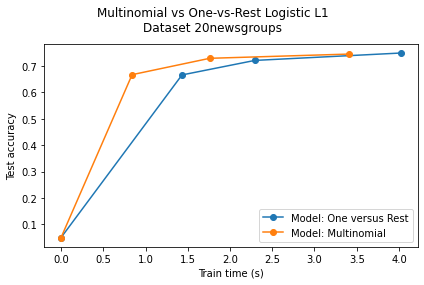

In [4]:
import timeit
import warnings

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.exceptions import ConvergenceWarning


warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")
t0 = timeit.default_timer()

# We use SAGA solver
solver = 'saga'

# Turn down for faster run time
n_samples = 10000

X, y = fetch_20newsgroups_vectorized(subset='all', return_X_y=True)
X = X[:n_samples]
y = y[:n_samples]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    stratify=y,
                                                    test_size=0.1)
train_samples, n_features = X_train.shape
n_classes = np.unique(y).shape[0]

print('Dataset 20newsgroup, train_samples=%i, n_features=%i, n_classes=%i'
      % (train_samples, n_features, n_classes))

models = {'ovr': {'name': 'One versus Rest', 'iters': [1, 2, 4]},
          'multinomial': {'name': 'Multinomial', 'iters': [1, 3, 7]}}

for model in models:
    # Add initial chance-level values for plotting purpose
    accuracies = [1 / n_classes]
    times = [0]
    densities = [1]

    model_params = models[model]

    # Small number of epochs for fast runtime
    for this_max_iter in model_params['iters']:
        print('[model=%s, solver=%s] Number of epochs: %s' %
              (model_params['name'], solver, this_max_iter))
        lr = LogisticRegression(solver=solver,
                                multi_class=model,
                                penalty='l1',
                                max_iter=this_max_iter,
                                random_state=42,
                                )
        t1 = timeit.default_timer()
        lr.fit(X_train, y_train)
        train_time = timeit.default_timer() - t1

        y_pred = lr.predict(X_test)
        accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
        density = np.mean(lr.coef_ != 0, axis=1) * 100
        accuracies.append(accuracy)
        densities.append(density)
        times.append(train_time)
    models[model]['times'] = times
    models[model]['densities'] = densities
    models[model]['accuracies'] = accuracies
    print('Test accuracy for model %s: %.4f' % (model, accuracies[-1]))
    print('%% non-zero coefficients for model %s, '
          'per class:\n %s' % (model, densities[-1]))
    print('Run time (%i epochs) for model %s:'
          '%.2f' % (model_params['iters'][-1], model, times[-1]))

fig = plt.figure()
ax = fig.add_subplot(111)

for model in models:
    name = models[model]['name']
    times = models[model]['times']
    accuracies = models[model]['accuracies']
    ax.plot(times, accuracies, marker='o',
            label='Model: %s' % name)
    ax.set_xlabel('Train time (s)')
    ax.set_ylabel('Test accuracy')
ax.legend()
fig.suptitle('Multinomial vs One-vs-Rest Logistic L1\n'
             'Dataset %s' % '20newsgroups')
fig.tight_layout()
fig.subplots_adjust(top=0.85)
run_time = timeit.default_timer() - t0
print('Example run in %.3f s' % run_time)
plt.show()

# MNIST classification using multinomial logistic + L1
Here we fit a multinomial logistic regression with L1 penalty on a subset of the MNIST digits classification task. We use the SAGA algorithm for this purpose: this a solver that is fast when the number of samples is significantly larger than the number of features and is able to finely optimize non-smooth objective functions which is the case with the l1-penalty. Test accuracy reaches > 0.8, while weight vectors remains sparse and therefore more easily interpretable.

Note that this accuracy of this l1-penalized linear model is significantly below what can be reached by an l2-penalized linear model or a non-linear multi-layer perceptron model on this dataset.



Sparsity with L1 penalty: 80.98%
Test score with L1 penalty: 0.8380
Example run in 22.105 s


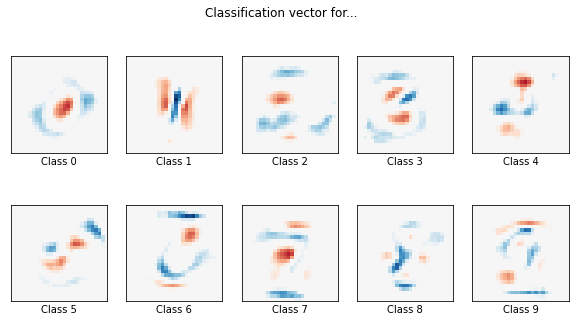

In [6]:
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

# Turn down for faster convergence
t0 = time.time()
train_samples = 5000

# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Turn up tolerance for faster convergence
clf = LogisticRegression(
    C=50. / train_samples, penalty='l1', solver='saga', tol=0.1
)
clf.fit(X_train, y_train)
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)

coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification vector for...')

run_time = time.time() - t0
print('Example run in %.3f s' % run_time)
plt.show()

# Linear Regression



LinearRegression fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the dataset, and the targets predicted by the linear approximation.

In [20]:
import numpy as np
from sklearn.linear_model import LinearRegression
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# y = 1 * x_0 + 2 * x_1 + 3
y = np.dot(X, np.array([1, 2])) + 3
reg = LinearRegression().fit(X, y)
reg.score(X, y)

print(reg.coef_)
print(reg.intercept_)
print(reg.predict(np.array([[3, 5]])))

[1. 2.]
3.0000000000000018
[16.]


# Linear Regression Example
The example below uses only the first feature of the diabetes dataset, in order to illustrate the data points within the two-dimensional plot. The straight line can be seen in the plot, showing how linear regression attempts to draw a straight line that will best minimize the residual sum of squares between the observed responses in the dataset, and the responses predicted by the linear approximation.

The coefficients, residual sum of squares and the coefficient of determination are also calculated.

Coefficients: 
 [938.23786125]
Mean squared error: 2548.07
Coefficient of determination: 0.47


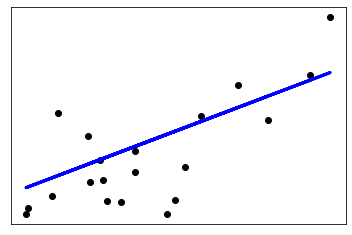

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Use only one feature
diabetes_X = diabetes_X[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(diabetes_y_test, diabetes_y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test,  color='black')
plt.plot(diabetes_X_test, diabetes_y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

# Non-negative least squares
In this example, we fit a linear model with positive constraints on the regression coefficients and compare the estimated coefficients to a classic linear regression.

NNLS R2 score 0.7436926291700348
OLS R2 score 0.7436926291700348


Text(0, 0.5, 'NNLS regression coefficients')

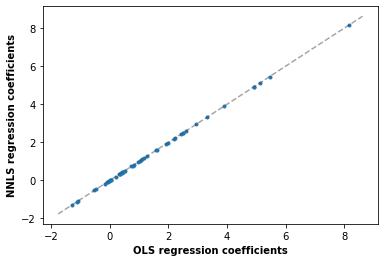

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

np.random.seed(42)

n_samples, n_features = 200, 50
X = np.random.randn(n_samples, n_features)
true_coef = 3 * np.random.randn(n_features)
# Threshold coefficients to render them non-negative
true_coef[true_coef < 0] = 0
y = np.dot(X, true_coef)

# Add some noise
y += 5 * np.random.normal(size=(n_samples, ))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)


reg_nnls = LinearRegression()
y_pred_nnls = reg_nnls.fit(X_train, y_train).predict(X_test)
r2_score_nnls = r2_score(y_test, y_pred_nnls)
print("NNLS R2 score", r2_score_nnls)

reg_ols = LinearRegression()
y_pred_ols = reg_ols.fit(X_train, y_train).predict(X_test)
r2_score_ols = r2_score(y_test, y_pred_ols)
print("OLS R2 score", r2_score_ols)

fig, ax = plt.subplots()
ax.plot(reg_ols.coef_, reg_nnls.coef_, linewidth=0, marker=".")

low_x, high_x = ax.get_xlim()
low_y, high_y = ax.get_ylim()
low = max(low_x, low_y)
high = min(high_x, high_y)
ax.plot([low, high], [low, high], ls="--", c=".3", alpha=.5)
ax.set_xlabel("OLS regression coefficients", fontweight="bold")
ax.set_ylabel("NNLS regression coefficients", fontweight="bold")

# Robust linear model estimation using RANSAC
In this example we see how to robustly fit a linear model to faulty data using the RANSAC algorithm.

Estimated coefficients (true, linear regression, RANSAC):
82.1903908407869 [54.17236387] [82.08533159]


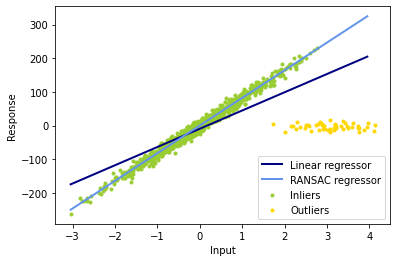

In [24]:
from matplotlib import pyplot as plt
from sklearn import linear_model, datasets

n_samples = 1000
n_outliers = 50

X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=10,
                                      coef=True, random_state=0)

# Add outlier data
np.random.seed(0)
X[:n_outliers] = 3 + 0.5 * np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = -3 + 10 * np.random.normal(size=n_outliers)

# Fit line using all data
lr = linear_model.LinearRegression()
lr.fit(X, y)

# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(X, y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Predict data of estimated models
line_X = np.arange(X.min(), X.max())[:, np.newaxis]
line_y = lr.predict(line_X)
line_y_ransac = ransac.predict(line_X)

# Compare estimated coefficients
print("Estimated coefficients (true, linear regression, RANSAC):")
print(coef, lr.coef_, ransac.estimator_.coef_)

lw = 2
plt.scatter(X[inlier_mask], y[inlier_mask], color='yellowgreen', marker='.',
            label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask], color='gold', marker='.',
            label='Outliers')
plt.plot(line_X, line_y, color='navy', linewidth=lw, label='Linear regressor')
plt.plot(line_X, line_y_ransac, color='cornflowerblue', linewidth=lw,
         label='RANSAC regressor')
plt.legend(loc='lower right')
plt.xlabel("Input")
plt.ylabel("Response")
plt.show()

# Sparsity Example: Fitting only features 1 and 2
Features 1 and 2 of the diabetes-dataset are fitted and plotted below. It illustrates that although feature 2 has a strong coefficient on the full model, it does not give us much regarding y when compared to just feature 1

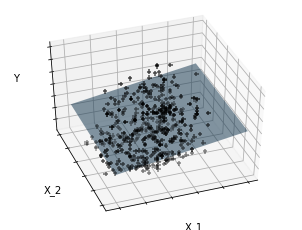

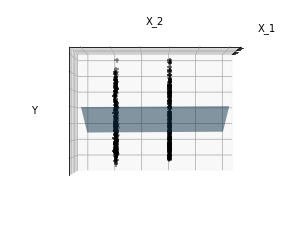

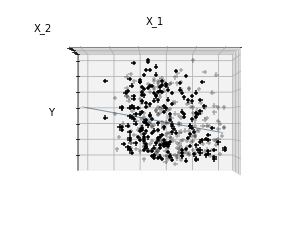

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

from sklearn import datasets, linear_model

X, y = datasets.load_diabetes(return_X_y=True)
indices = (0, 1)

X_train = X[:-20, indices]
X_test = X[-20:, indices]
y_train = y[:-20]
y_test = y[-20:]

ols = linear_model.LinearRegression()
ols.fit(X_train, y_train)


# #############################################################################
# Plot the figure
def plot_figs(fig_num, elev, azim, X_train, clf):
    fig = plt.figure(fig_num, figsize=(4, 3))
    plt.clf()
    ax = Axes3D(fig, elev=elev, azim=azim)

    ax.scatter(X_train[:, 0], X_train[:, 1], y_train, c='k', marker='+')
    ax.plot_surface(np.array([[-.1, -.1], [.15, .15]]),
                    np.array([[-.1, .15], [-.1, .15]]),
                    clf.predict(np.array([[-.1, -.1, .15, .15],
                                          [-.1, .15, -.1, .15]]).T
                                ).reshape((2, 2)),
                    alpha=.5)
    ax.set_xlabel('X_1')
    ax.set_ylabel('X_2')
    ax.set_zlabel('Y')
    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])


# Generate the three different figures from different views
elev = 43.5
azim = -110
plot_figs(1, elev, azim, X_train, ols)

elev = -.5
azim = 0
plot_figs(2, elev, azim, X_train, ols)

elev = -.5
azim = 90
plot_figs(3, elev, azim, X_train, ols)

plt.show()